In [3]:
from __future__ import print_function

from miscc.utils import mkdir_p
from miscc.utils import build_super_images
from miscc.losses import sent_loss, words_loss
from miscc.config import cfg, cfg_from_file

from datasets import TextDataset
from datasets import prepare_data

from model import TEXT_TRANSFORMER_ENCODERv2, CNN_ENCODER

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import sys
import time
import random
import pprint
import datetime
import dateutil.tz
    
import argparse
import numpy as np
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import PositionalEmbedding as PE
from torch.utils.tensorboard import SummaryWriter

# dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
# sys.path.append(dir_path)

In [35]:
cfg_from_file('cfg/DAMSM/coco.yml')

imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
batch_size = cfg.TRAIN.BATCH_SIZE
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, 'train',
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform)
print(dataset.n_words, dataset.embeddings_num)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True,
    shuffle=False, num_workers=int(cfg.WORKERS))


/media/MyDataStor2/zhanghex/torch-master/MMRL/code/miscc/config.py:104: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))
/media/MyDataStor2/zhanghex/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Load filenames from: /media/MyDataStor1/mmrl/MMRL/data/coco/train/filenames.pickle (82783)
Load filenames from: /media/MyDataStor1/mmrl/MMRL/data/coco/test/filenames.pickle (40470)
Load from:  /media/MyDataStor1/mmrl/MMRL/data/coco/captions.pickle
/media/MyDataStor1/mmrl/MMRL/data/coco/train
27297 5


In [36]:
d = iter(dataloader).next()

In [37]:
i, a, b, c, d = prepare_data(d)

In [38]:
i[0].shape

torch.Size([96, 3, 299, 299])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


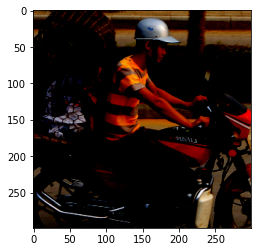

In [42]:
import matplotlib.pyplot as plt
plt.imshow(i[0][2].cpu().numpy().transpose((1,2,0)))

355.0625